In [ ]:
## Part 3
# Problem in R code when taking the cummulative integral it makes it constant and not linear  (integrating piecewise constant will give piecewise linear)
# Should we either use regressogram or our original kernel estimator

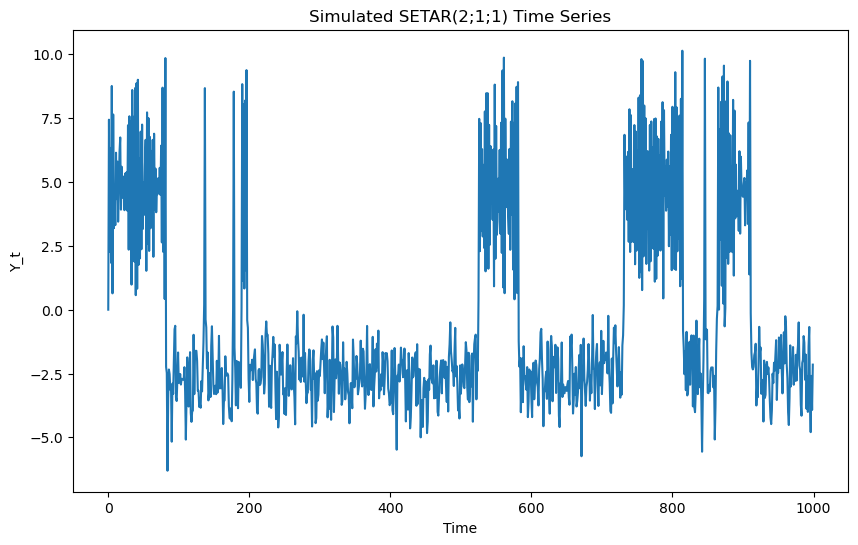

In [82]:
# Simulate SETAR(2;1;1) 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(50)
a_0_1 = -2
a_1_1 = 0.2
a_0_2 = 9
a_1_2 = -0.9

n = 1000
Y = np.zeros(n)
for t in range(1, n):
    if Y[t-1] < 0:
        Y[t] = a_0_1 + a_1_1* Y[t-1] + np.random.normal()
    else:
        Y[t] = a_0_2 + a_1_2 * Y[t-1] + np.random.normal()
df = pd.DataFrame(Y, columns=['Value'])
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x=df.index, y='Value')
plt.title('Simulated SETAR(2;1;1) Time Series')
plt.xlabel('Time')
plt.ylabel('Y_t')
plt.show()

  18  10  14  16  21  14  20  20  14  14   5   7]


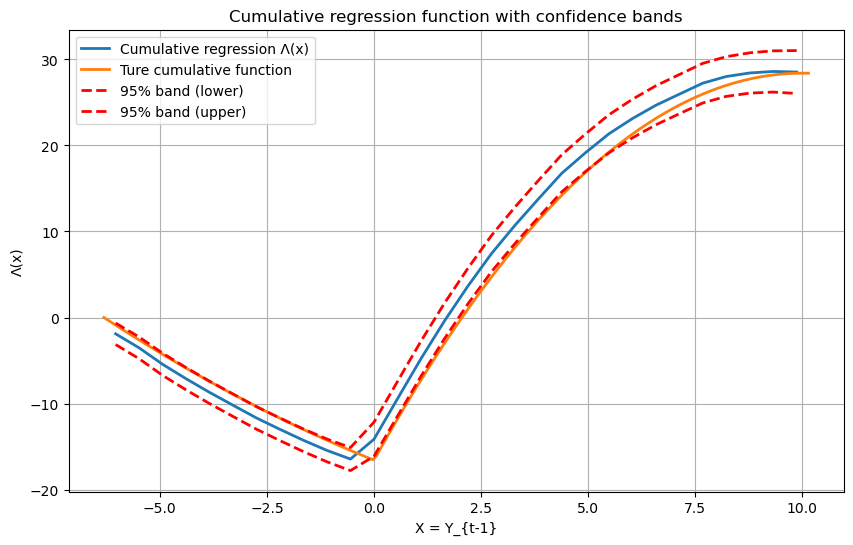

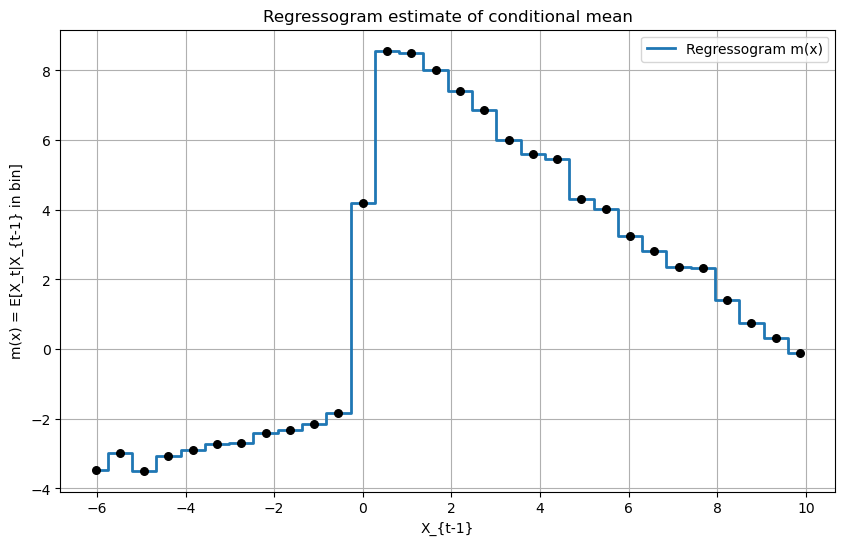

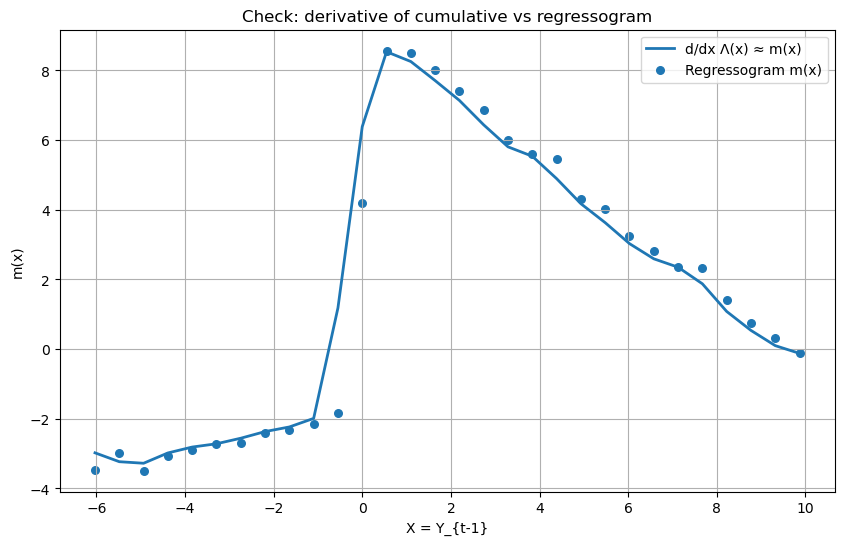

In [ ]:

X = Y[:-1]   # predictor = lagged values
Z = Y[1:]    # response
N = len(X)

# regressogram
n_bin = 30
breaks = np.linspace(np.min(X), np.max(X), n_bin+1)
h = breaks[1] - breaks[0] # bin width
bin_centers = 0.5 * (breaks[:-1] + breaks[1:])

lambda_hat = np.zeros(n_bin)
f_hat = np.zeros(n_bin)
gamma = np.zeros(n_bin)
counts = np.zeros(n_bin, dtype=int)

for i in range(n_bin):
    left, right = breaks[i], breaks[i+1]
    if i < n_bin - 1:
        mask = (X >= left) & (X < right)
    else:
        mask = (X >= left) & (X <= right)
    X_bin, Z_bin = X[mask], Z[mask] # Points in bin i
    counts[i] = len(X_bin)
    if counts[i] > 0:
        lambda_hat[i] = Z_bin.mean() # Sum from equation 3.6 from the book
        f_hat[i] = counts[i] / (n_bin * h) # Used to calculate confidence bands using eq. 3.10
        gamma[i] = np.sum((Z_bin - lambda_hat[i])**2) / counts[i]
    else:
        lambda_hat[i] = np.nan
        f_hat[i] = np.nan
        gamma[i] = np.nan

if not np.all(counts >= 5):
    print("Warning: Some bins have < 5 obs. Counts:", counts)

# Cumulative regression + confidence bands
c_alpha = 1.273
Lambda = np.nancumsum(lambda_hat * h)

h_hat = gamma / f_hat
h_hat = np.nan_to_num(h_hat, nan=0.0, posinf=0.0, neginf=0.0)
H_hat = np.cumsum(h_hat * h)
H_hat_b = H_hat[-1] if H_hat.size > 0 else 0.0

factor = c_alpha * (n_bin**(-0.5)) * np.sqrt(H_hat_b) if H_hat_b > 0 else 0.0
Lambda_lower = Lambda - factor * (1 + H_hat / H_hat_b) if H_hat_b > 0 else Lambda.copy()
Lambda_upper = Lambda + factor * (1 + H_hat / H_hat_b) if H_hat_b > 0 else Lambda.copy()

def cum_int(x, a=-5):
    if x < 0:
        return (-2*x + 0.1*x**2) - (-2*a + 0.1*a**2)
    else:
        return (2*a - 0.1*a**2) + (9*x - 0.45*x**2)

x_true = np.linspace(np.min(X), np.max(X), 200)

y_true = [cum_int(xi, a = np.min(X)) for xi in x_true]


# (a) Cumulative regression function with bands
plt.figure(figsize=(10, 6))
plt.plot(bin_centers, Lambda, label='Cumulative regression Λ(x)', linewidth=2)
plt.plot(x_true, y_true, label = 'Ture cumulative function', linewidth=2)
plt.plot(bin_centers, Lambda_lower, 'r--', label='95% band (lower)', linewidth=2)
plt.plot(bin_centers, Lambda_upper, 'r--', label='95% band (upper)', linewidth=2)
plt.xlabel('X = Y_{t-1}')
plt.ylabel('Λ(x)')
plt.title('Cumulative regression function with confidence bands')
plt.legend()
plt.grid(True)
plt.show()

# (b) Regressogram (histogram regression)
plt.figure(figsize=(10, 6))
plt.step(bin_centers, lambda_hat, where='mid', linewidth=2, label='Regressogram m(x)')
plt.scatter(bin_centers, lambda_hat, c='k', zorder=3, s=30)
plt.xlabel('X_{t-1}')
plt.ylabel('m(x) = E[X_t|X_{t-1} in bin]')
plt.title('Regressogram estimate of conditional mean')
plt.legend()
plt.grid(True)
plt.show()

# (c) Derivative of cumulative vs regressogram
m_from_Lambda = np.gradient(Lambda, h)
plt.figure(figsize=(10, 6))
plt.plot(bin_centers, m_from_Lambda, label='d/dx Λ(x) ≈ m(x)', linewidth=2)
plt.scatter(bin_centers, lambda_hat, label='Regressogram m(x)', s=30)
plt.xlabel('X = Y_{t-1}')
plt.ylabel('m(x)')
plt.title('Check: derivative of cumulative vs regressogram')
plt.legend()
plt.grid(True)
plt.show()